✅ Preprocessing and Feature Generation Complete.
⏳ Training Random Forest Classifier...
✅ Model Training Complete.

--- Model Evaluation (Click Prediction) ---
Accuracy Score:  0.8338
Precision Score: 0.0829
Recall Score:    0.3119
F1 Score:        0.1310
--- Generating Evaluation Graphs ---


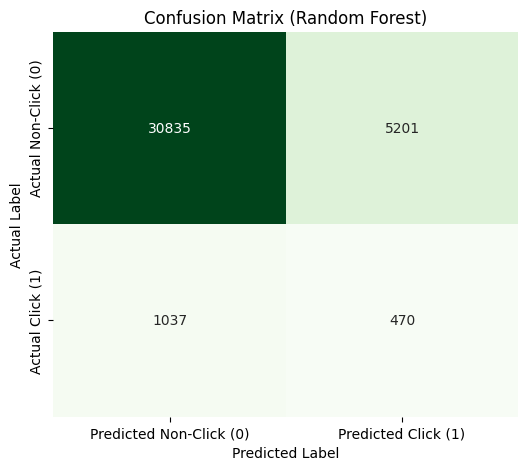

✅ Confusion Matrix Plot Generated.


<Figure size 600x500 with 0 Axes>

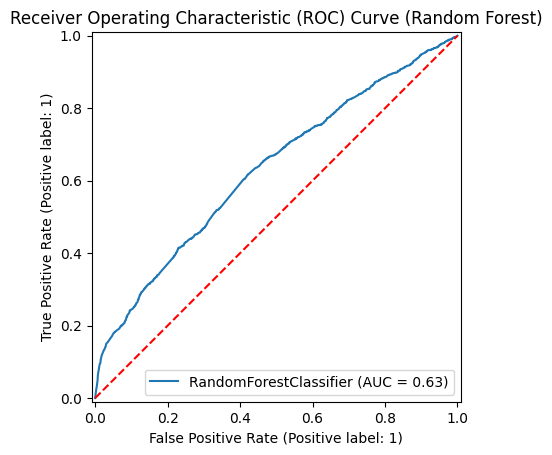

✅ ROC Curve Plot Generated.

📰 Interactive News Recommendation System 📰
Available Users: 4640
Example User IDs: U13740, U91836, U73700, U34670, U8125...

Enter a UserID (e.g., U12345) or type 'random' for a random user: U13740
How many recommendations do you want (e.g., 5)? 3

⏳ Generating 3 recommendations for User U13740...

⭐ Top 3 Recommendations for User U13740 ⭐
|    | Title                                                                                 | Category   | Click Probability   |
|:---|:--------------------------------------------------------------------------------------|:-----------|:--------------------|
| 1  | Rip Taylor's Cause of Death Revealed, Memorial Service Scheduled for Later This Month | tv         | 0.7479              |
| 2  | Broadway Actress Laurel Griggs Dies at Age 13                                         | music      | 0.7147              |
| 3  | Broadway Star Laurel Griggs Suffered Asthma Attack Before She Died at Age 13          | music      | 0

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, RocCurveDisplay
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

NEWS_FILE = 'news.tsv' # Provided file
BEHAVIORS_FILE = 'behaviors.tsv' # Provided file
NEWS_COLUMNS = ['NewsID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbstractEntities']

if not os.path.exists(NEWS_FILE) or not os.path.exists(BEHAVIORS_FILE):
    print("Error: Required files 'news.tsv' and 'behaviors.tsv' not found.")
    print("Please ensure they are in the same directory as the script.")
    sys.exit()

try:
    N_ROWS = 5000
    df_news = pd.read_csv(NEWS_FILE, sep='\t', names=NEWS_COLUMNS, encoding='utf-8', index_col=False)
    df_behaviors = pd.read_csv(BEHAVIORS_FILE, sep='\t', names=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions'], encoding='utf-8', index_col=False, nrows=N_ROWS)

    interaction_data = []
    for index, row in df_behaviors.iterrows():
        for item in row['Impressions'].split(' '):
            try:
                news_id, label = item.split('-')
                interaction_data.append({'UserID': row['UserID'], 'NewsID': news_id, 'Label': int(label)})
            except ValueError:
                continue

    df_interactions = pd.DataFrame(interaction_data)
    if df_interactions.empty:
        print("Error: No valid interactions could be extracted. Exiting.")
        sys.exit()

    df_news['content'] = df_news['Title'].fillna('') + ' ' + df_news['Abstract'].fillna('')
    valid_news_ids = df_interactions['NewsID'].unique()
    df_news_filtered = df_news[df_news['NewsID'].isin(valid_news_ids)].copy()

    tfidf = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = tfidf.fit_transform(df_news_filtered['content']).toarray()
    tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
    df_news_filtered.reset_index(drop=True, inplace=True)
    df_news_features = pd.concat([df_news_filtered[['NewsID', 'Category']], tfidf_df], axis=1)

    df_category_ohe = pd.get_dummies(df_news_features['Category'], prefix='cat')
    df_news_features = pd.concat([df_news_features.drop('Category', axis=1), df_category_ohe], axis=1)

    df_final = pd.merge(df_interactions, df_news_features, on='NewsID', how='inner')
    PROCESSED_FILE = 'processed_recommendation_data.csv'
    df_final.to_csv(PROCESSED_FILE, index=False)

except Exception as e:
    print(f"An error occurred during preprocessing: {e}")
    sys.exit()

print("✅ Preprocessing and Feature Generation Complete.")
df_final = pd.read_csv(PROCESSED_FILE)
df_news_all = pd.read_csv(NEWS_FILE, sep='\t', names=NEWS_COLUMNS, encoding='utf-8', index_col=False)

feature_cols = [col for col in df_final.columns if col not in ['UserID', 'NewsID', 'Label']]
X = df_final[feature_cols]
y = df_final['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced')
print("⏳ Training Random Forest Classifier...")
rf_model.fit(X_train, y_train)
print("✅ Model Training Complete.")

y_pred = rf_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*50)
print("--- Model Evaluation (Click Prediction) ---")
print(f"Accuracy Score:  {accuracy:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score:    {recall:.4f}")
print(f"F1 Score:        {f1:.4f}")
print("="*50)

print("--- Generating Evaluation Graphs ---")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted Non-Click (0)', 'Predicted Click (1)'],
            yticklabels=['Actual Non-Click (0)', 'Actual Click (1)'])
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
print("✅ Confusion Matrix Plot Generated.")

plt.figure(figsize=(6, 5))
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title('Receiver Operating Characteristic (ROC) Curve (Random Forest)')
plt.plot([0, 1], [0, 1], 'r--') # Random guess line
plt.show()
print("✅ ROC Curve Plot Generated.")
print("="*50)


df_news_features_cand = df_final.drop(['UserID', 'Label'], axis=1).drop_duplicates()
def recommend_news(model, user_id, df_interactions, df_news_features_cand, df_news_all, n=10):
    """Generates N recommendations for a user based on predicted click probability."""

    candidate_news_df = df_news_features_cand.copy()

    X_pred = candidate_news_df.drop('NewsID', axis=1)
    probabilities = model.predict_proba(X_pred)[:, 1]
    candidate_news_df['probability'] = probabilities

    seen_news_ids = df_interactions[df_interactions['UserID'] == user_id]['NewsID'].unique()

    top_recommendations = candidate_news_df[~candidate_news_df['NewsID'].isin(seen_news_ids)]
    top_recommendations = top_recommendations.sort_values(by='probability', ascending=False).head(n)

    if top_recommendations.empty:
        return pd.DataFrame(columns=['NewsID', 'probability', 'Title', 'Category'])

    rec_results = pd.merge(top_recommendations[['NewsID', 'probability']],
                           df_news_all[['NewsID', 'Title', 'Category']],
                           on='NewsID', how='left')

    return rec_results


def run_recommendation_ui(model, df_interactions, df_news_features_cand, df_news_all):

    unique_user_ids = df_interactions['UserID'].unique()

    print("\n" + "="*50)
    print("📰 Interactive News Recommendation System 📰")
    print("="*50)
    print(f"Available Users: {len(unique_user_ids)}")
    print(f"Example User IDs: {', '.join(unique_user_ids[:5])}...")

    while True:
        user_input = input(f"\nEnter a UserID (e.g., U12345) or type 'random' for a random user: ").strip()

        if user_input.lower() == 'random':
            user_id = df_interactions['UserID'].sample(1).iloc[0]
            print(f"Selected random UserID: {user_id}")
            break
        elif user_input in unique_user_ids:
            user_id = user_input
            break
        else:
            print("Invalid UserID. Please try again or use 'random'.")

    while True:
        try:
            n_recs = int(input("How many recommendations do you want (e.g., 5)? "))
            if n_recs > 0:
                break
            else:
                print("Please enter a positive number.")
        except ValueError:
            print("Invalid input. Please enter a whole number.")

    print(f"\n⏳ Generating {n_recs} recommendations for User {user_id}...")
    recommendation_df = recommend_news(model, user_id, df_interactions, df_news_features_cand, df_news_all, n=n_recs)

    print("\n" + "="*50)
    print(f"⭐ Top {len(recommendation_df)} Recommendations for User {user_id} ⭐")
    print("="*50)

    if recommendation_df.empty:
        print("Could not generate any unique recommendations for this user.")
    else:
        recommendation_df.index = np.arange(1, len(recommendation_df) + 1)
        output_df = recommendation_df[['Title', 'Category', 'probability']].copy()
        output_df.columns = ['Title', 'Category', 'Click Probability']

        print(output_df.to_markdown(numalign="left", stralign="left", floatfmt=".4f"))

    print("\n" + "="*50)

run_recommendation_ui(rf_model, df_final, df_news_features_cand, df_news_all)
